In [2]:
%matplotlib inline
import numpy as np
import lib.io.stan
import lib.syn_data
import matplotlib.pyplot as plt
import os

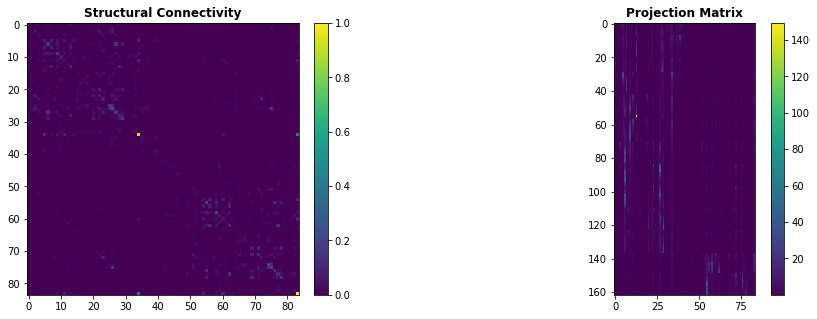

In [19]:
results_dir = 'results/exp7.1'
os.makedirs(f'{results_dir}/figures',exist_ok=True)
os.makedirs(f'{results_dir}/logs',exist_ok=True)
np.random.seed(0)

# x = np.r_[2:12:2]
# y = np.repeat(np.array([3.0]),np.size(x))
# src_locs = np.array(list(zip(x,y)))
# nNodes = np.size(src_locs,0)
# x = np.r_[1:12:1]
# y = np.repeat(np.array([1.0]),np.size(x))
# snsr_locs = np.array(list(zip(x,y)))
# nSnsrs = np.size(snsr_locs,0)
SC = np.loadtxt('data/CJ/connectivity/weights.txt')
SC = SC / np.max(SC)
proj_mat = np.loadtxt('data/CJ/gain_inv-square.txt')
nNodes = SC.shape[0]
nSnsrs = proj_mat.shape[0]

# plt.figure(figsize=[12,3])
# plt.subplot(131)
# plt.plot(src_locs[:,0],src_locs[:,1],'r*',label='sources')
# plt.plot(snsr_locs[:,0],snsr_locs[:,1],'ko',label='sensors')
# plt.xlim([0,15])
# plt.ylim([0,5])
# plt.grid(1,alpha=0.2)
# plt.legend(loc='upper right')

# ax = plt.subplot(132)
# SC = lib.syn_data.gen_con(nNodes)
plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
plt.imshow(SC)
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title("Structural Connectivity",fontweight="bold")



# proj_mat = lib.syn_data.comp_proj_mat(src_locs,snsr_locs)

plt.subplot(1,2,2)
plt.imshow(proj_mat)
plt.colorbar(fraction=0.046,pad=0.04)
plt.gca().set_title("Projection Matrix",fontweight="bold")

# plt.tight_layout()
plt.savefig(f'{results_dir}/figures/network.png')


np.savez(f'{results_dir}/network.npz', SC=SC, proj_mat=proj_mat)



In [38]:
nn = nNodes
ns = nSnsrs
I1 = 3.1
tau0 = 30.0
k = 5
Ic = np.zeros(nn)

x0 = -2.5*np.ones(nn)
x0[6] = -1.8
x0[[9,27]] = -2.2
time_scale = 1.0
time_step = 0.1
sigma = 0.01
nt = 50*int(1/time_step)
epsilon = 0.1
amplitude = 1.0
offset = 0.0

x_init = -0.5*np.ones(nn)
z_init = 1.5*np.ones(nn)
z_eta = np.random.normal(0.0, 1.0, [nt-1, nn])

data = {'nn':nn, 'ns':ns, 'nt':nt, 'I1':I1, 'tau0':tau0, 'Ic':Ic, 'SC':SC, 
        'gain': proj_mat, 'sigma':sigma, 'k':k, 'epsilon': epsilon, 'amplitude': amplitude,
        'offset': offset, 'x0':x0, 'time_scale':time_scale, 'time_step':time_step,
        'x_init':x_init, 'z_init':z_init, 'z_eta': z_eta}

lib.io.stan.rdump(f'{results_dir}/sim_data.R',data)

stan_fname = './vep-src-infer-sim'
lib.io.stan.create_process(['bash','/home/anirudhnihalani/scripts/stancompile.sh', stan_fname],block=True)
sim_cmd = f'{stan_fname} sample algorithm=fixed_param num_samples=1 num_warmup=0 data \
file={results_dir}/sim_data.R output file={results_dir}/sim_out.csv'
lib.io.stan.create_process(sim_cmd.split(),block=True)

/home/anirudhnihalani/vep.stan
make: `/home/anirudhnihalani/vep.stan/./vep-src-infer-sim' is up to date.
method = sample (Default)
  sample
    num_samples = 1
    num_warmup = 0
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.050000000000000003 (Default)
      delta = 0.80000000000000004 (Default)
      kappa = 0.75 (Default)
      t0 = 10 (Default)
      init_buffer = 75 (Default)
      term_buffer = 50 (Default)
      window = 25 (Default)
    algorithm = fixed_param
id = 0 (Default)
data
  file = results/exp7.1/sim_data.R
init = 2 (Default)
random
  seed = 3147964191
output
  file = results/exp7.1/sim_out.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)

Iteration: 1 / 1 [100%]  (Sampling)

 Elapsed Time: 0 seconds (Warm-up)
               0.43 seconds (Sampling)
               0.43 seconds (Total)



0

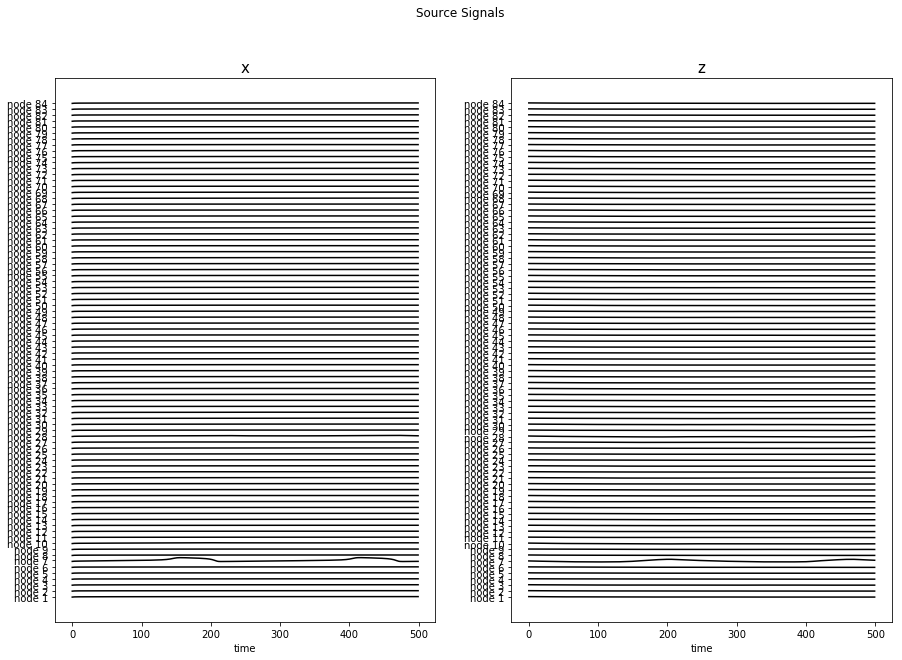

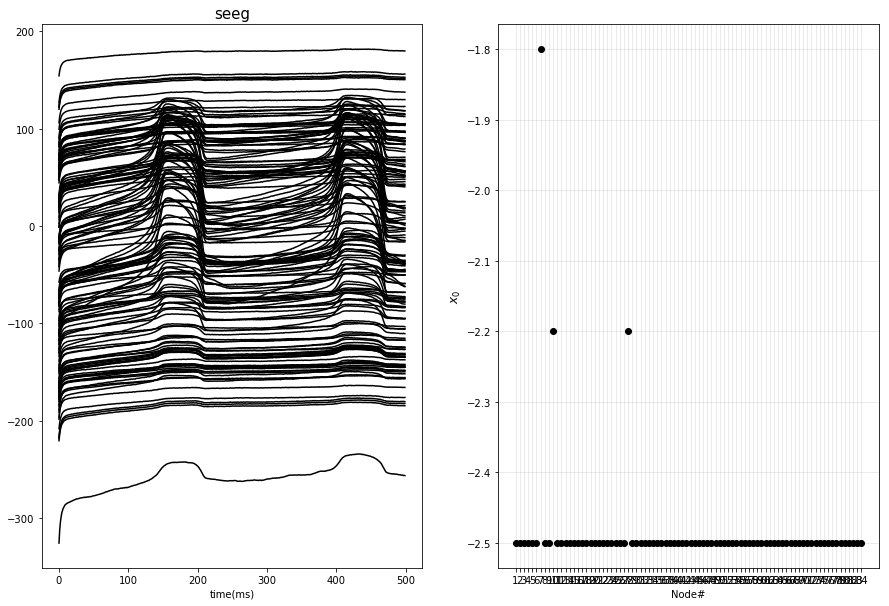

In [39]:
t = lib.io.stan.parse_csv(f'{results_dir}/sim_out.csv')

x = t['x'][0]
z = t['z'][0]
seeg = t['seeg'][0]

plt.figure(figsize=[15,10])
plt.subplot(121)
for i in range(nn):
    plt.plot(x.T[:,i]/4.0 + i,label=f'node{i+1}',color='black')
plt.yticks(np.mean(x.T/4.0 + np.arange(nn),axis=0), map(lambda x: f'node {x}',np.arange(1,nn+1)))
plt.xlabel('time')
plt.gca().set_title('x',fontsize=15.0)
plt.suptitle('Source Signals')
plt.subplot(122)
for i in range(nn):
    plt.plot(z.T[:,i]/4.0 + i,label=f'node{i}',color='black')
plt.yticks(np.mean(z.T/4.0 + np.arange(nn),axis=0), map(lambda x: f'node {x}',np.arange(1,nn+1)))
plt.xlabel('time')
plt.gca().set_title('z',fontsize=15.0)
plt.savefig(f'{results_dir}/figures/src_signals.png')

plt.figure(figsize=[15,10])
plt.subplot(1,2,1)
plt.plot(seeg.T + np.r_[0:2*ns:2],'k')
# plt.yticks(np.mean(seeg.T + np.r_[0:2*ns:2],axis=0), map(lambda x: f'snsr {x}',np.arange(1,ns+1)))
plt.xlabel('time(ms)')
plt.title('seeg',fontsize=15.0)
plt.subplot(1,2,2)
plt.plot(np.r_[1:nn+1],x0,'ko')
plt.xlabel('Node#')
plt.xticks(np.arange(1,nn+1),map(str,np.arange(1,nn+1)))
plt.ylabel('$x_0$',fontsize=12.0)
plt.grid(alpha=0.3)
plt.savefig(f'{results_dir}/figures/seeg.png')

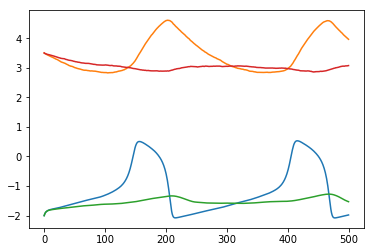

In [42]:
plt.figure()
plt.plot(x[6,:])
plt.plot(z[6,:])
plt.plot(x[27,:])
plt.plot(z[27,:])

In [ ]:
plt.figure(figsize=[15,3])
for i in range(nn):
    plt.subplot(1,5,i+1)
    plt.plot(x[i,:],'k')
    plt.xlabel('time')
    plt.ylabel('x',fontsize=15.0)
    plt.ylim([-3.0,1.0])
    plt.gca().set_title(f'node {i+1}')
plt.savefig(f'{results_dir}/figures/src_signals_2.png')    
    
plt.tight_layout()
plt.figure(figsize=[15,3])
for i in range(nn):
    plt.subplot(1,5,i+1)
    plt.plot(z[i,:],'k')
    plt.xlabel('time')
    plt.ylabel('z',fontsize=15.0)
    plt.ylim([2.0,5.0])
    plt.gca().set_title(f'node {i+1}')
plt.tight_layout()
plt.savefig(f'{results_dir}/figures/src_signals_3.png')

In [ ]:
sim_data = lib.io.stan.rload(f'{results_dir}/sim_data.R')
data = {'ns':sim_data['ns'], 'nn':sim_data['nn'], 'nt':sim_data['nt'],
        'gain':sim_data['gain'], 'epsilon':sim_data['epsilon'], 'seeg':seeg.T}    
    
lib.io.stan.rdump(f'{results_dir}/fit_data.R',data)

stan_fname = './vep-src-infer'
lib.io.stan.create_process(['bash','/home/anirudhnihalani/scripts/stancompile.sh', stan_fname],block=True)

nchains = 8
with open('vep-src-infer.sh','r') as fd:
    slurm_script = fd.read().format(results_dir,nchains)
with open('tmp/vep-src-infer.sh','w') as fd:
    fd.write(slurm_script)
lib.io.stan.create_process(['sbatch','tmp/vep-src-infer.sh'],block=False)


KeyboardInterrupt: 

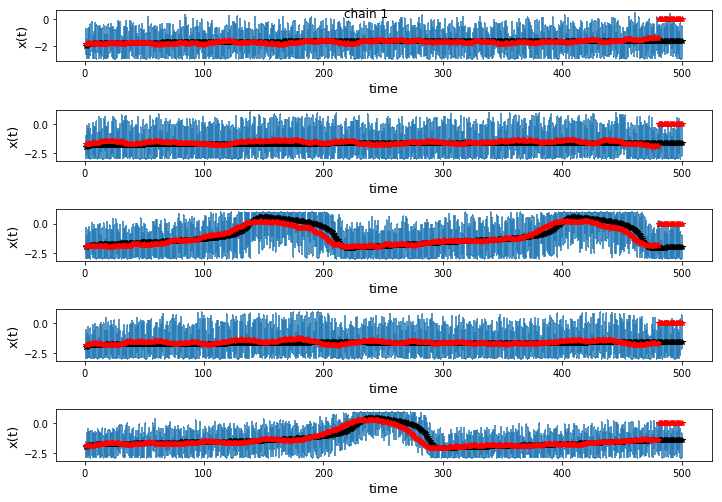

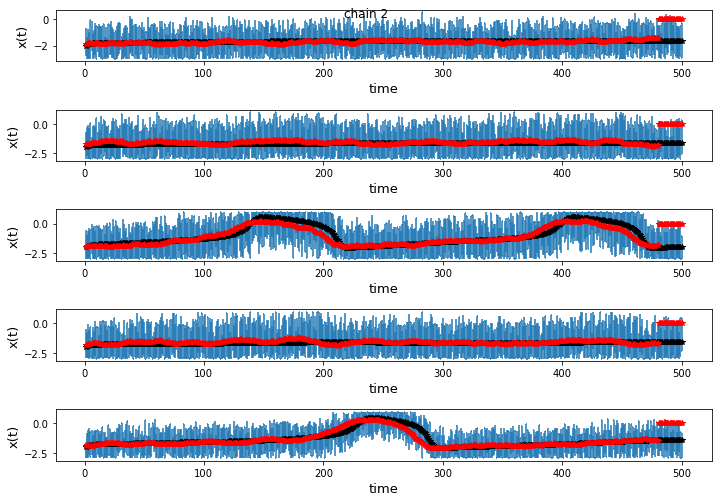

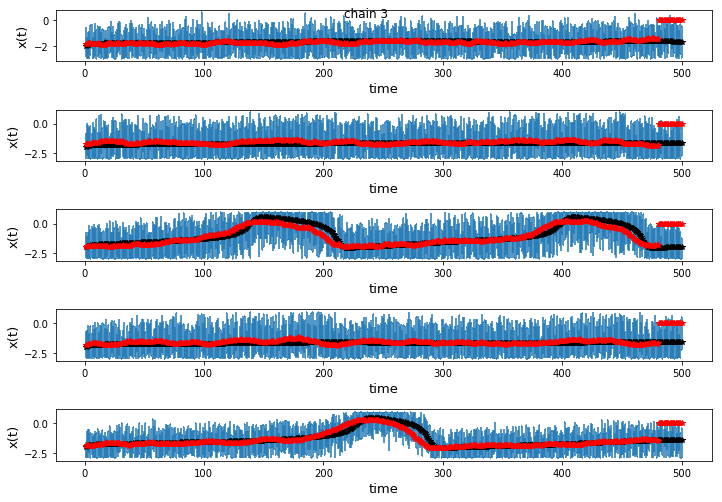

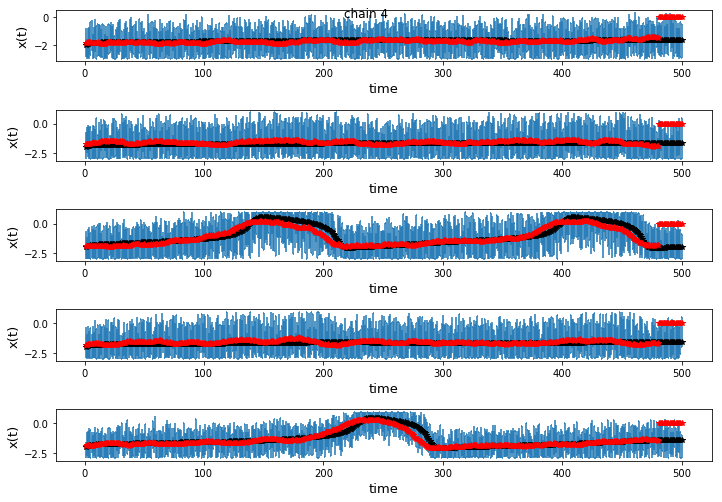

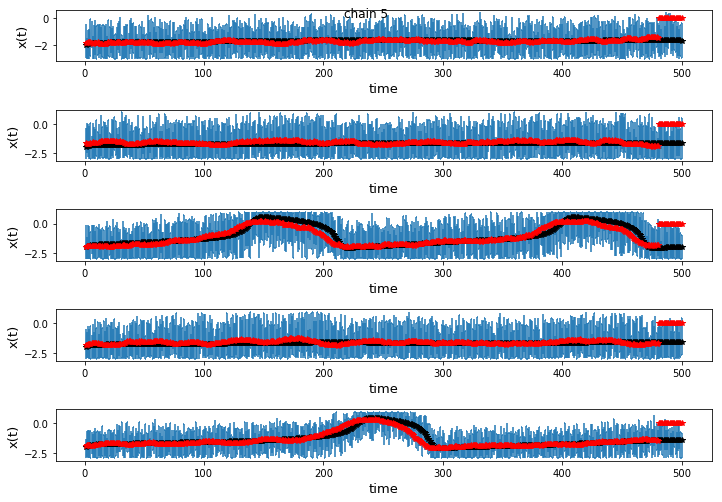

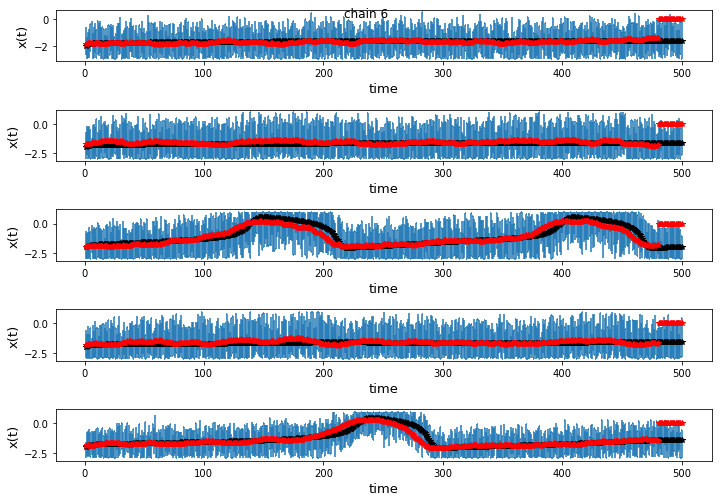

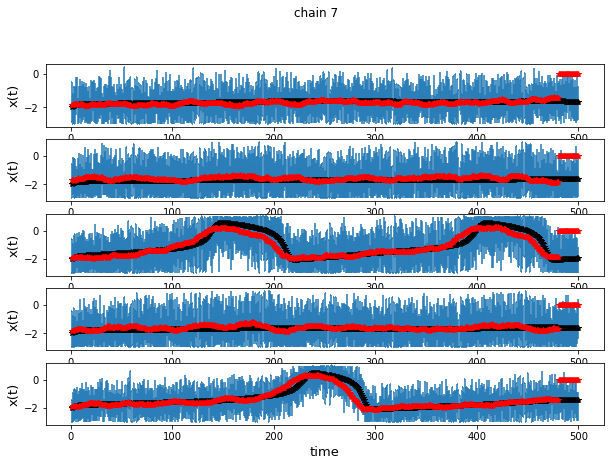

In [3]:
results_dir = 'results/exp7'
def mov_avg(x,win_size):
    y = np.zeros(len(x))
    for i in range(len(x)-win_size):
        y[i] = np.mean(x[i:i+win_size])
    return y

sim_data = lib.io.stan.rload(f'{results_dir}/sim_data.R')
sim_out = lib.io.stan.parse_csv(f'{results_dir}/sim_out.csv')
chains = [1,2,3,4,5,6,7,8]
for i,chain_no in enumerate(chains):
    t = lib.io.stan.parse_csv(f'{results_dir}/samples_chain{chain_no}.csv')
    plt.figure(figsize=[10,8])
    for j in range(sim_data['nn']):
        plt.subplot(sim_data['nn']+1,1,j+1)
        start_idx = 0
        end_idx = sim_data['nt']
        x = t['x'][500:,j,start_idx:end_idx]
        xmu = np.mean(x,axis=0)
        plt.violinplot(x)
        plt.plot(np.r_[start_idx:end_idx]-start_idx+1,sim_out['x'][0,j,start_idx:end_idx],'k*')
#         plt.plot(np.r_[start_idx:end_idx]-start_idx+1,stats.mode(x)[0][0],'r*')
        plt.plot(np.r_[start_idx:end_idx]-start_idx+1,mov_avg(xmu,20),'r*')
        plt.xlabel('time',fontsize=13)
        plt.ylabel('x(t)',fontsize=13)
    plt.suptitle(f'chain {chain_no}')
    plt.tight_layout()